In [1]:
import pykrev as pk
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import seaborn as sns

In [2]:
sampleNames = [f.split('.')[0] for f in os.listdir() if f.endswith('csv') and 'PW' in f]
samplePaths = [f for f in os.listdir() if f.endswith('csv') and 'PW' in f]

In [3]:
analysisDict = pk.msTupleDict()

In [4]:
for name,path in zip(sampleNames,samplePaths):
    corems = pd.read_csv(path)
    analysisDict[name] = pk.read_corems(corems)

In [5]:
analysisDf = analysisDict.to_DataFrame()

In [128]:
#Add sample metadata to analysis Df
extraction = []
depths = []
for name in sampleNames:
    depth = name.split('_')[0]
    depths.append(int(depth))
    if 'PW1' in name:
        extraction.append('Rhizon')
    elif 'PW2' in name:
        extraction.append('Squeeze')

analysisDf['depth'] = pd.Categorical(depths)
analysisDf['extraction'] = pd.Categorical(extraction)

In [168]:
#Add information about mean element counts
C = []
H = []
N = []
O = []
intense = []
stdIntensity = []
for name in sampleNames:
    msTuple = analysisDict[name]
    intense.append(sum(msTuple.intensity > 1e8))
    stdIntensity.append(np.std(msTuple.intensity))
    elementDict = pk.element_counts(msTuple)
    elementData = pd.DataFrame(elementDict)
    C.append(np.mean(elementData['C']))
    H.append(np.mean(elementData['H']))
    N.append(np.mean(elementData['N']))
    O.append(np.mean(elementData['O']))

analysisDf['mean O'] = O
analysisDf['intense'] = intense
analysisDf['std intensity'] = stdIntensity

In [162]:
#Add information about sample diversity
simpson = []
shannon = []
for name in sampleNames:
    sampleTuple  = analysisDict[name]
    diversityDict = pk.diversity_indices(sampleTuple, verbose='False', indices = ['SW', 'GS'])
    simpson.append(diversityDict['D_a_GS'])
    shannon.append(diversityDict['D_a_SW'])
analysisDf['simpson'] = simpson
analysisDf['shannon'] = shannon

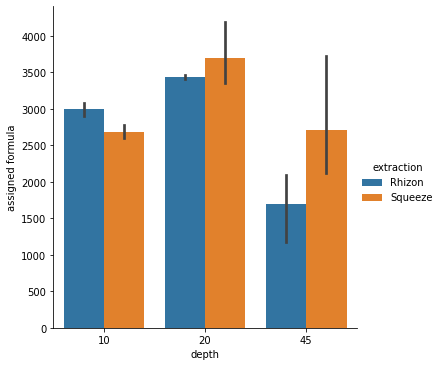

In [163]:
ax = sns.catplot(x="depth", y="assigned formula", hue="extraction", kind="bar", data=analysisDf)

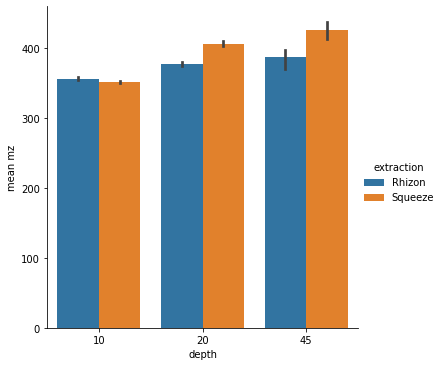

In [171]:
ax = sns.catplot(x="depth", y="mean mz", hue="extraction", kind="bar", data=analysisDf)

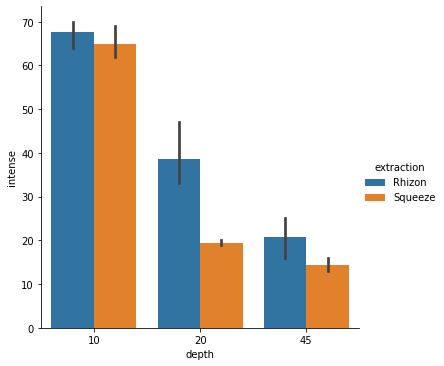

In [170]:
ax = sns.catplot(x="depth", y="intense", hue="extraction", kind="bar", data=analysisDf)

In [174]:
OrdinationMatrix = analysisDict.to_OrdinationMatrix(impute_value = 0)

In [196]:
NormMatrix = pk.normalise_intensity(OrdinationMatrix, norm_method = 'zscore')

In [197]:
from sklearn.decomposition import PCA

In [198]:
pca = PCA() #instance of the PCA class, here we can define parameters about the PCA 
pca.fit(NormMatrix) #fit the PCA intialised with default parameters to our data
pca_result = pca.transform(NormMatrix) # transform our data with the fitted model

In [199]:
analysisDf['PC1'] = pca_result[:,0]
analysisDf['PC2'] = pca_result[:,1]

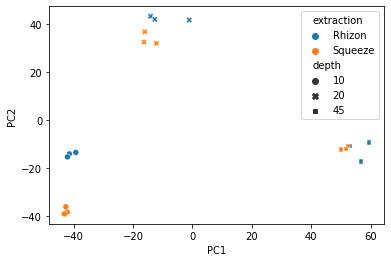

In [200]:
ax = sns.scatterplot(x="PC1", y="PC2", style = 'depth', hue="extraction", data=analysisDf)